In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data_lagged.csv")

# Разделение данных

In [3]:
X1 = data[data["label"] == 1]["batch_id"].unique()
X2 = data[data["label"] == 2]["batch_id"].unique()
X3 = data[data["label"] == 3]["batch_id"].unique()

X1_train, X1_test = train_test_split(X1,train_size = 0.7, random_state = 42)
X2_train, X2_test = train_test_split(X2,train_size = 0.7, random_state = 42)
X3_train, X3_test = train_test_split(X3,train_size = 0.7, random_state = 42)
X_train = [*X1_train, *X2_train, *X3_train]
X_test = [*X1_test, *X2_test, *X3_test]
data_train = data[data["batch_id"].apply(lambda x: x in X_train)]
data_test = data[data["batch_id"].apply(lambda x: x in X_test)]

X = data_train.drop(['msec', 'Valence', 'Arousal', 'label', 'batch_id'], axis = 1)
X_test = data_test.drop(['msec', 'Valence', 'Arousal', 'label', 'batch_id'], axis = 1)
y_valence = data_train.iloc[:,4:5]
y_arousal = data_train.iloc[:,5:6]
y_valence_test = data_test.iloc[:,4:5]
y_arousal_test = data_test.iloc[:,5:6]

# Модели из коробки

In [4]:
def models_test(X, y, X_test, y_test):
    models = [DummyRegressor(), 
              linear_model.LinearRegression(), 
              linear_model.BayesianRidge(), 
              linear_model.ElasticNet(), 
              SVR(),  
              KNeighborsRegressor(),
              RandomForestRegressor(random_state = 42),
              GradientBoostingRegressor(random_state = 42),
              CatBoostRegressor(random_state = 42, verbose = False, iterations = 100, learning_rate = 0.1, depth = 3), 
              LGBMRegressor(random_state = 42, max_depth = 3), 
              XGBRegressor(random_state = 42, n_estimators = 100, max_depth = 3)]
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    for model in models:
        model.fit(X, y) 
        l = str(model)
        if '(' in l:
            m["R2_train"][l[:l.index('(')]] = r2_score(y, model.predict(X))
            m["MAE_train"][l[:l.index('(')]] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"][l[:l.index('(')]] = mean_squared_error(y, model.predict(X))
            m["R2_test"][l[:l.index('(')]] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"][l[:l.index('(')]] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"][l[:l.index('(')]] = mean_squared_error(y_test, model.predict(X_test))
        else:
            m["R2_train"]['CatBoost'] = r2_score(y, model.predict(X))
            m["MAE_train"]['CatBoost'] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"]['CatBoost'] = mean_squared_error(y, model.predict(X))
            m["R2_test"]['CatBoost'] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"]['CatBoost'] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"]['CatBoost'] = mean_squared_error(y_test, model.predict(X_test))
    return pd.DataFrame(m)

In [5]:
TestModelsArousal = models_test(X, y_arousal, X_test, y_arousal_test)
TestModelsValence = models_test(X, y_valence, X_test, y_valence_test)

In [6]:
TestModelsArousal

,R2_train,MAE_train,MSE_train,R2_test,MAE_test,MSE_test
DummyRegressor,0.000000,0.078661,0.011081,-0.036512,0.080516,0.008689
LinearRegression,0.122665,0.071667,0.009722,0.013543,0.076818,0.008269
BayesianRidge,0.122206,0.071631,0.009727,0.013190,0.076867,0.008272
ElasticNet,0.065016,0.075596,0.010360,-0.021166,0.080038,0.008560
SVR,0.267700,0.071792,0.008115,-0.096888,0.081296,0.009195
KNeighborsRegressor,0.552806,0.045551,0.004955,-0.242466,0.077460,0.010415
RandomForestRegressor,0.917206,0.020673,0.000917,-0.055096,0.074691,0.008845
GradientBoostingRegressor,0.617761,0.047701,0.004236,-0.055282,0.072428,0.008846
CatBoost,0.435935,0.057637,0.006250,0.028607,0.071746,0.008143
LGBMRegressor,0.561757,0.050799,0.004856,-0.002180,0.072295,0.008401


In [7]:
TestModelsValence

,R2_train,MAE_train,MSE_train,R2_test,MAE_test,MSE_test
DummyRegressor,0.000000,0.279655,0.139557,-0.000720,0.319861,0.180549
LinearRegression,0.304694,0.241880,0.097035,0.037024,0.343349,0.173739
BayesianRidge,0.304074,0.241902,0.097122,0.038841,0.342821,0.173411
ElasticNet,0.290755,0.244811,0.098980,0.057125,0.337471,0.170112
SVR,0.371952,0.214046,0.087649,0.022696,0.335645,0.176324
KNeighborsRegressor,0.692270,0.143102,0.042946,0.150382,0.292068,0.153287
RandomForestRegressor,0.936817,0.067488,0.008818,0.220626,0.290666,0.140614
GradientBoostingRegressor,0.655977,0.171465,0.048011,0.211234,0.301720,0.142308
CatBoost,0.544759,0.196734,0.063532,0.218011,0.301522,0.141085
LGBMRegressor,0.628631,0.175924,0.051827,0.222131,0.299109,0.140342


# Модели c погружением после подбора параметров

In [8]:
def models_test_val(X, y, X_test, y_test):
    models = [DummyRegressor(), 
              linear_model.LinearRegression(), 
              linear_model.BayesianRidge(), 
              linear_model.ElasticNet(), 
              SVR(kernel = 'linear'),  
              KNeighborsRegressor(n_neighbors = 62),
              RandomForestRegressor(n_estimators=400, max_depth=4, random_state=42),
              GradientBoostingRegressor(max_depth = 1, n_estimators = 100, random_state = 42),
              CatBoostRegressor(random_state = 42, verbose = False, iterations = 200, depth = 2, train_dir = 'catboost_with_lagged_log'), 
              LGBMRegressor(max_depth = 1, n_estimators = 100, random_state = 42), 
              XGBRegressor(n_estimators = 100, max_depth = 1, random_state = 42)]
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    for model in models:
        model.fit(X, y) 
        l = str(model)
        if '(' in l:
            m["R2_train"][l[:l.index('(')]] = r2_score(y, model.predict(X))
            m["MAE_train"][l[:l.index('(')]] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"][l[:l.index('(')]] = mean_squared_error(y, model.predict(X))
            m["R2_test"][l[:l.index('(')]] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"][l[:l.index('(')]] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"][l[:l.index('(')]] = mean_squared_error(y_test, model.predict(X_test))
        else:
            m["R2_train"]['CatBoost'] = r2_score(y, model.predict(X))
            m["MAE_train"]['CatBoost'] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"]['CatBoost'] = mean_squared_error(y, model.predict(X))
            m["R2_test"]['CatBoost'] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"]['CatBoost'] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"]['CatBoost'] = mean_squared_error(y_test, model.predict(X_test))
    return pd.DataFrame(m)

In [9]:
MTV = models_test_val(X, y_valence, X_test, y_valence_test)
MTV

,R2_train,MAE_train,MSE_train,R2_test,MAE_test,MSE_test
DummyRegressor,0.000000,0.279655,0.139557,-0.000720,0.319861,0.180549
LinearRegression,0.304694,0.241880,0.097035,0.037024,0.343349,0.173739
BayesianRidge,0.304074,0.241902,0.097122,0.038841,0.342821,0.173411
ElasticNet,0.290755,0.244811,0.098980,0.057125,0.337471,0.170112
SVR,0.293659,0.238967,0.098575,0.046053,0.334157,0.172110
KNeighborsRegressor,0.473739,0.210221,0.073444,0.154522,0.313509,0.152540
RandomForestRegressor,0.484579,0.208967,0.071931,0.216453,0.304680,0.141367
GradientBoostingRegressor,0.393027,0.225771,0.084707,0.109703,0.322662,0.160626
CatBoost,0.609424,0.182739,0.054508,0.190531,0.303740,0.146043
LGBMRegressor,0.389919,0.226472,0.085141,0.106584,0.323177,0.161189


In [10]:
def models_test_ar(X, y, X_test, y_test):
    models = [DummyRegressor(), 
              linear_model.LinearRegression(), 
              linear_model.BayesianRidge(), 
              linear_model.ElasticNet(), 
              SVR(kernel = 'linear'),  
              KNeighborsRegressor(n_neighbors = 94),
              RandomForestRegressor(random_state = 42, max_depth = 2, n_estimators = 400),
              GradientBoostingRegressor(max_depth = 1, n_estimators = 100, random_state = 42),
              CatBoostRegressor(random_state = 42, verbose = False, iterations = 400, depth = 1, train_dir = 'catboost_with_lagged_log'), 
              LGBMRegressor(max_depth = 1, n_estimators = 300, random_state = 42), 
              XGBRegressor(n_estimators = 100, max_depth = 1, random_state = 42)]
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    for model in models:
        model.fit(X, y) 
        l = str(model)
        if '(' in l:
            m["R2_train"][l[:l.index('(')]] = r2_score(y, model.predict(X))
            m["MAE_train"][l[:l.index('(')]] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"][l[:l.index('(')]] = mean_squared_error(y, model.predict(X))
            m["R2_test"][l[:l.index('(')]] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"][l[:l.index('(')]] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"][l[:l.index('(')]] = mean_squared_error(y_test, model.predict(X_test))
        else:
            m["R2_train"]['CatBoost'] = r2_score(y, model.predict(X))
            m["MAE_train"]['CatBoost'] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"]['CatBoost'] = mean_squared_error(y, model.predict(X))
            m["R2_test"]['CatBoost'] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"]['CatBoost'] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"]['CatBoost'] = mean_squared_error(y_test, model.predict(X_test))
    return pd.DataFrame(m)

In [11]:
MTA = models_test_ar(X, y_arousal, X_test, y_arousal_test)
MTA

,R2_train,MAE_train,MSE_train,R2_test,MAE_test,MSE_test
DummyRegressor,0.000000,0.078661,0.011081,-0.036512,0.080516,0.008689
LinearRegression,0.122665,0.071667,0.009722,0.013543,0.076818,0.008269
BayesianRidge,0.122206,0.071631,0.009727,0.013190,0.076867,0.008272
ElasticNet,0.065016,0.075596,0.010360,-0.021166,0.080038,0.008560
SVR,0.105793,0.075740,0.009909,-0.023426,0.081018,0.008579
KNeighborsRegressor,0.241272,0.066004,0.008407,0.070225,0.071855,0.007794
RandomForestRegressor,0.223075,0.068391,0.008609,0.023781,0.075506,0.008184
GradientBoostingRegressor,0.283208,0.065316,0.007943,0.059707,0.073180,0.007882
CatBoost,0.330436,0.062495,0.007419,0.059810,0.071244,0.007881
LGBMRegressor,0.324500,0.062918,0.007485,0.054102,0.071871,0.007929


# Сравнение моделей до и после подбора параметров

### Сравнение для Valence

In [13]:
TestModelsValence['Модель'] = ["С погружением, без подбора параметров"]*11
MTV['Модель'] = ["С погружением и с подбором параметров"]*11
df_Valence = TestModelsValence.append(MTV)

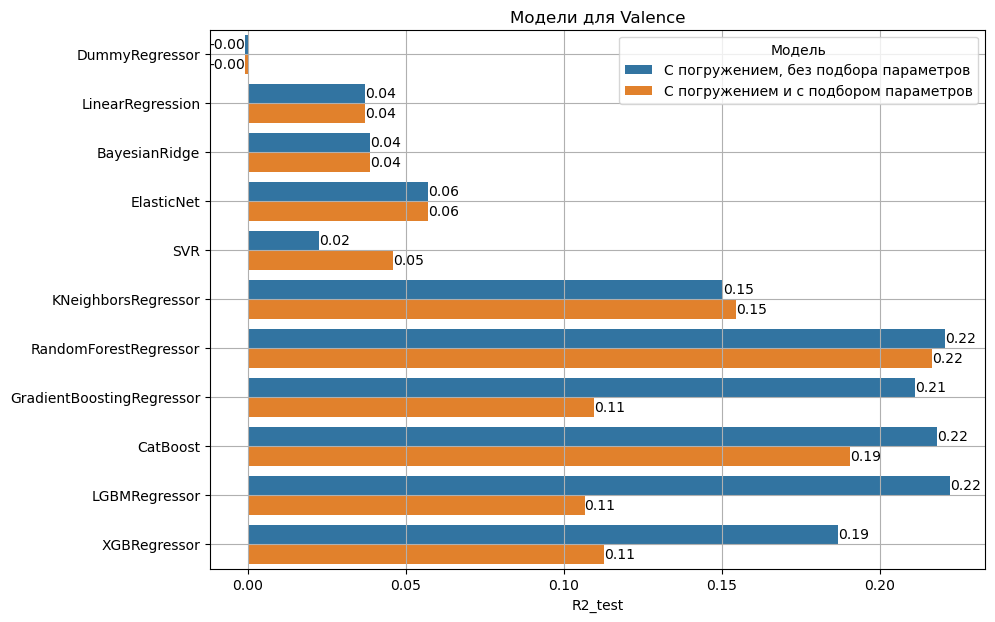

In [14]:
fig, ax = plt.subplots(figsize = (10, 7))
ax = sns.barplot(data = df_Valence, x = 'R2_test', y = df_Valence.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.grid()
plt.title('Модели для Valence')
plt.show()

### Сравнение для Arousal

In [15]:
TestModelsArousal['Модель'] = ["С погружением, без подбора параметров"]*11
MTA['Модель'] = ["С погружением и с подбором параметров"]*11
df_Arousal = TestModelsArousal.append(MTA)

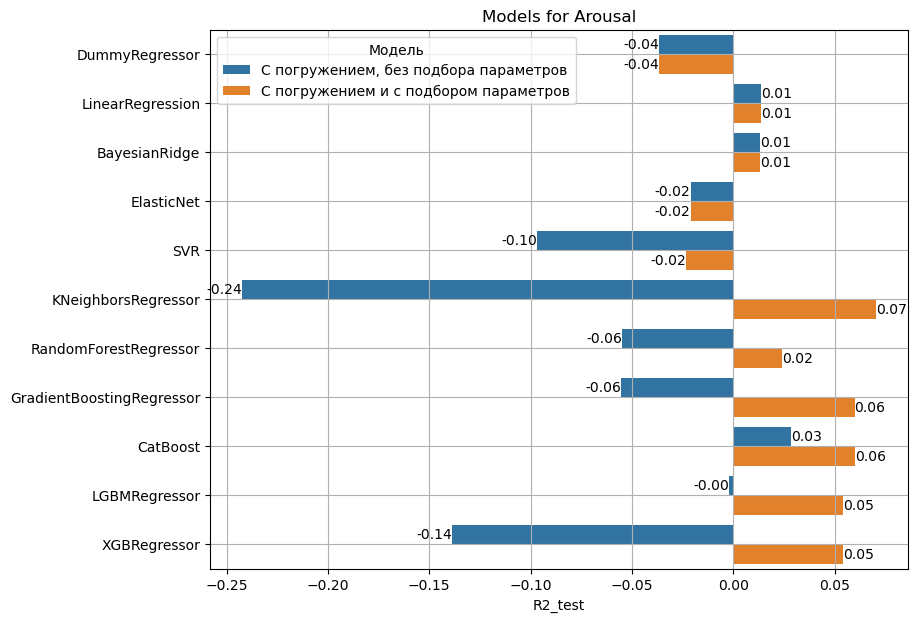

In [16]:
fig, ax = plt.subplots(figsize = (9, 7))
ax = sns.barplot(data = df_Arousal, x = 'R2_test', y = df_Arousal.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.grid()
plt.title('Models for Arousal')
plt.show()

### Сохранение результатов работы моделей

In [17]:
with pd.ExcelWriter('Model_results.xlsx', mode="a") as writer:
    df_Arousal.to_excel(writer, sheet_name='Results_with_lagging_for_Arousal')
    df_Valence.to_excel(writer, sheet_name='Results_with_lagging_for_Valence')